<a href="https://colab.research.google.com/github/wgova/time_series_trade/blob/master/notebooks/clustering_tsfresh_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Required packages

In [7]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# !pip install -q oec
# import oec
import re
import pandas as pd
import numpy as np
import json
from random import sample
import random
import itertools
import os, os.path, csv, requests, pathlib
from datetime import datetime
import math
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')
from sklearn.cluster import AgglomerativeClustering,\
KMeans,\
SpectralClustering,\
DBSCAN
from scipy.cluster.hierarchy import fcluster, ward, dendrogram
from scipy.cluster.vq import kmeans,vq
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,\
StandardScaler\
,normalize
from sklearn.metrics.cluster import homogeneity_score
from sklearn import decomposition
from scipy.stats.mstats import winsorize
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_samples,\
silhouette_score
from sklearn.decomposition import PCA

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Functions for automating clustering

In [8]:
def remove_null_values(df,threshold:int=0.8):
  pct_null = df.isnull().sum() / len(df)
  missing_features = pct_null[pct_null > threshold].index
  df.drop(missing_features, axis=1, inplace=True)
  df.fillna(0,inplace=True)
  return df

def check_outliers(df):
    col = list(df)
    outliers = pd.DataFrame(columns=['columns','Outliers'])
    
    for column in col:
        if column in df.select_dtypes(include=np.number).columns:
            q1 = df[column].quantile(0.25) 
            q3 = df[column].quantile(0.75)
            below = q1 - (1.5*q3 - q1)
            above = q3 + (1.5*q3 - q1)
            outliers = outliers.append({'columns':column,'Outliers':df.loc[(df[column] < below) | (df[column] > above)].shape[0]},ignore_index=True)
    return outliers
    
def removing_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.1, 0.1],inclusive=(True, True))
    return dataframe

# Functions for dendrograms
# given a linkage model, plog dendogram, with the colors indicated by the a cutoff point at which we define clusters
#https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
def plot_dendrogram(raw_ts_dataframe,name_of_dataset, **kwargs):
    model = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(raw_ts_dataframe.T.values)
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    fig = plt.figure(figsize=(10,5.5))
    fig.suptitle(f'Hierarchical clusters: {name_of_dataset}')
    dendrogram(linkage_matrix, **kwargs)
    plt.savefig(f"hierarchical_{name_of_dataset}")
    return linkage_matrix

def plot_elbow_silhoutte_k_evaluation(name_of_data: str,data_array,max_clusters):
  range_n_clusters = range(2,max_clusters)
  elbow = []
  s_score = []
  for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters = n_clusters, random_state=42,init='k-means++',max_iter=1000,n_init=1)
    cluster_labels = clusterer.fit_predict(data_array)
    # Average silhouette score
    silhouette_avg = silhouette_score(data_array, cluster_labels)
    s_score.append(silhouette_avg)
    # Average SSE"
    elbow.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center
    
  fig = plt.figure(figsize=(10,5.5))
  fig.suptitle(f"K-means clusters for {name_of_data}", fontsize=16)
  fig.add_subplot(121)
  plt.plot(range_n_clusters, elbow,'b-',label=f'{name_of_data} SSE')
  plt.xlabel("Number of cluster")
  plt.ylabel("Sum of squared error(SSE)")
  plt.legend()
  
  fig.add_subplot(122)
  # plt.title("Covid-19 Rt values silhouette method results")
  plt.plot(range_n_clusters, s_score,'b-',label=f'{name_of_data} \n Silhouette Score')
  plt.xlabel("Number of cluster")
  plt.ylabel("Silhouette Score")
  plt.legend()
  plt.show()

def plot_kmeans_clusters(data_array,number_of_clusters,name_of_data:str):
  # computing K-Means with K = number_of_clusters
  centroids,_ = kmeans(data_array,number_of_clusters)
  # assign each sample to a cluster
  idx,_ = vq(data_array,centroids)
  # some plotting using numpy's logical indexing
  fig, ax = plt.subplots(figsize=(10,5.5))
  fig.suptitle(f"K-means clusters for {name_of_data}", fontsize=12)
  for cluster in range(number_of_clusters):
    colours = ['ob','ok','or','og','om','oc','oy']
    ax.plot(data_array[idx==cluster,0],data_array[idx==cluster,1],colours[cluster],label=f'cluster {cluster}')
    plt.legend()
  plt.savefig(f"{PATH}/images/k_means_{name_of_data}")
  plt.show()
  return idx

## Data processing

In [33]:
PATH = f'/content/drive/My Drive/Stellenbosch/Webster'
def load_features_data(ref: range,root_path: str,target_features):
  path_to_target_features = os.path.join(root_path,target_features)
  data = os.listdir(path_to_target_features)[ref]
  product_df = pd.read_csv(f'{path_to_target_features}/{data}',index_col='id')
  product_df_no_nulls = remove_null_values(product_df)
  product_df_no_nulls.columns = [re.sub('^export_val__',"", x) for x in product_df_no_nulls.columns]
  return product_df_no_nulls

def filter_useful_features(features_df,features_to_exclude):
  exclude_list = []
  feats = features_df.columns
  for i in features_to_exclude:
    feature_cols = features_df.filter(regex=i,axis=1).columns.to_list()
    exclude_list.extend(feature_cols)
  features_filtered_df = features_df[feats[~feats.isin(exclude_list)]]
  return features_filtered_df

all_eff_features = load_features_data(0,PATH,'efficient_parameters')

In [35]:
redundant_features = ['fft_coefficient','cwt_coefficients','count','change_quantiles','last_location_',
                 'agg_autocorrelation','index_mass_quantile','sum_values','sum_values','has_duplicate',
                 'length','quantile','ratio_beyond_r_sigma','ratio_value_number_to_time_series_length',
                 'agg','large_standard_deviation','number_crossing_m','number_cwt_peaks','reversal',
                  'value_count','spkt_welch_density','range_count','larger','variation_coefficient',
                 'max_langevin_fixed_point','reoccurring','symmetry_looking','variation','longest_strike_',
                 'variance_larger_than_standard_deviation']
features_filtered = filter_useful_features(all_eff_features,redundant_features)

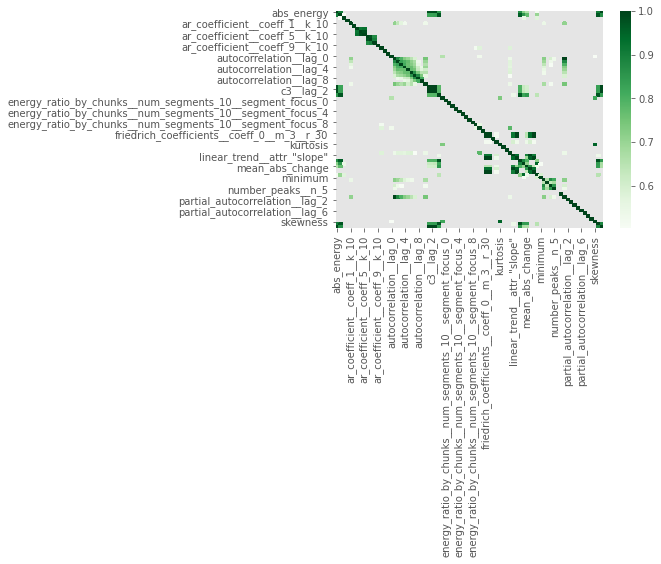

In [39]:
min_feats = ['kurtosis','variance','mean','skewness','standard_deviation',
             'median','sum_values','maximum','length','minimum']
# features_filtered_df = product_df_no_outliers[min_feats]
# features_filtered_df.columns = [re.sub('^augmented_dickey_fuller__attr',"ADF_", x) for x in features_filtered_df.columns]
# features_filtered_df.columns = [re.sub('^partial_autocorrelation__',"pac_", x) for x in features_filtered_df.columns]
# features_filtered_df.columns = [re.sub('^number_peaks__',"peaks_", x) for x in features_filtered_df.columns]

corr = features_filtered.corr()
kot = corr[corr >= .5]
sns.heatmap(kot,cmap="Greens")

27

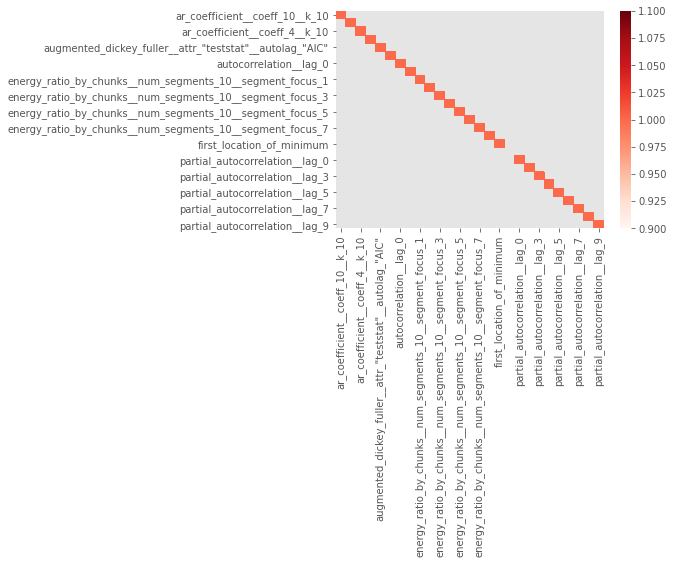

In [41]:
corr = features_filtered.corr().abs()
corr_array = corr.unstack()
sorted_corr_array = corr_array.sort_values(kind="quicksort",ascending=False).drop_duplicates()
sorted_corr = pd.DataFrame(sorted_corr_array).reset_index()
sorted_corr.rename(columns={"level_0":"feature_1","level_1":"feature_2",0:"score"},inplace=True)
corr_feats = sorted_corr[sorted_corr['score']>=0.5]
corr_feats = corr_feats['feature_2'].values

feats_corr = features_filtered.columns
features_uncorrelated = features_filtered[feats_corr[~feats_corr.isin(corr_feats)]]

correlated = features_uncorrelated.corr()
red_flags = correlated[correlated >= .50]

sns.heatmap(red_flags,cmap="Reds")
len(features_uncorrelated.columns)

In [42]:
scaler = StandardScaler()
# scaler.fit_transform(uncorrelated_product_df_no_outliers)
product_scaled_uncorrelated = pd.DataFrame(scaler.fit_transform(features_uncorrelated),
                              columns = features_uncorrelated.columns,
                              index=features_uncorrelated.index)
len(product_scaled_uncorrelated.columns)

27

## Load data

In [43]:
#TODO: https://stats.stackexchange.com/questions/427327/simple-outlier-detection-for-time-series
random.seed(20)
random_countries = sample(list(features_uncorrelated.index),5)
product_excl_countries = features_uncorrelated[features_uncorrelated.index.isin(random_countries)]
product_by_countries = features_uncorrelated[features_uncorrelated.index.isin(random_countries)]
X_scaled_transposed = np.asarray(features_uncorrelated)
X_scaled_transposed.shape

(241, 27)

## EDA and correlation analysis

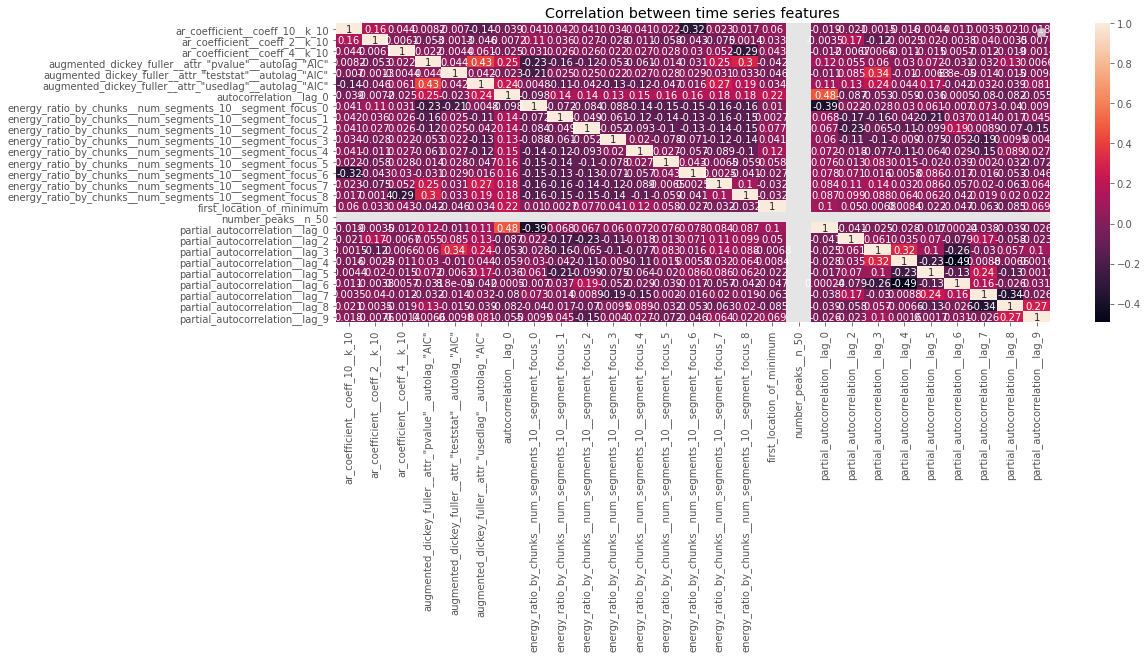

In [44]:
fig = plt.figure(figsize=(16,5.5))
sns.heatmap(features_uncorrelated.corr(),annot=True)
plt.title("Correlation between time series features")
plt.savefig(f"{PATH}/images/correlation_stats_features")
plt.legend(features_uncorrelated.columns)
plt.show()

# Clustering TSFRESH extracted features

## Hierarchical clustering TS features

<Figure size 1008x432 with 0 Axes>

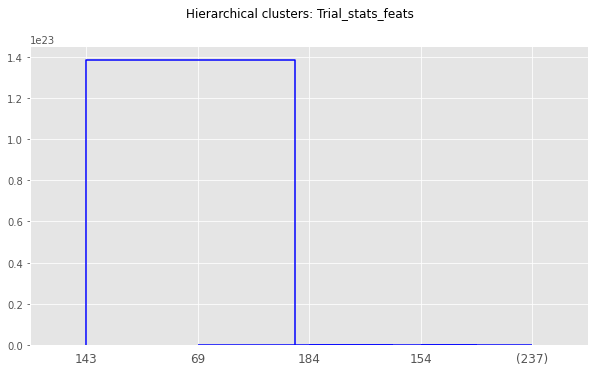

Unique clusters: [1 2 3 4 5 6 7 8 9]


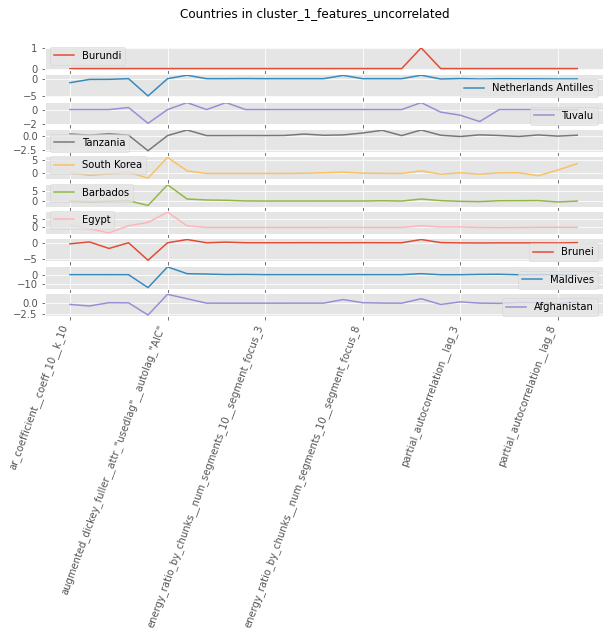

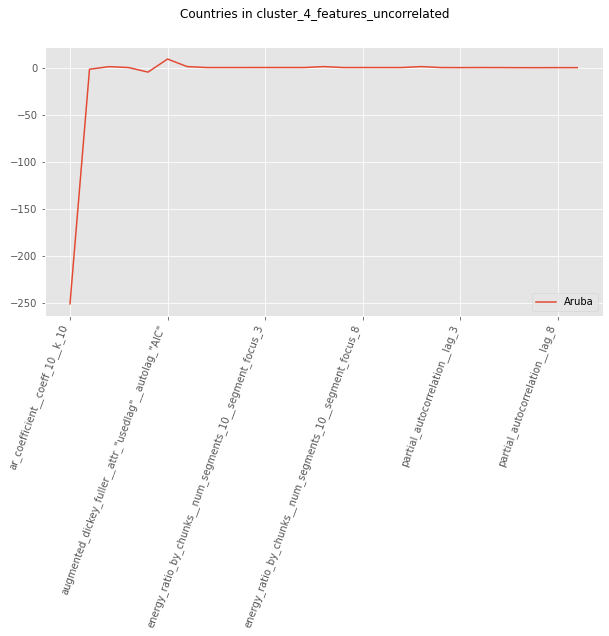

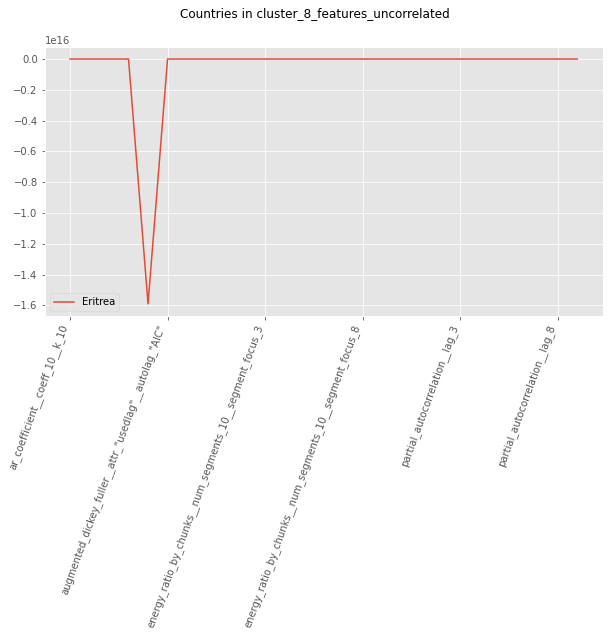

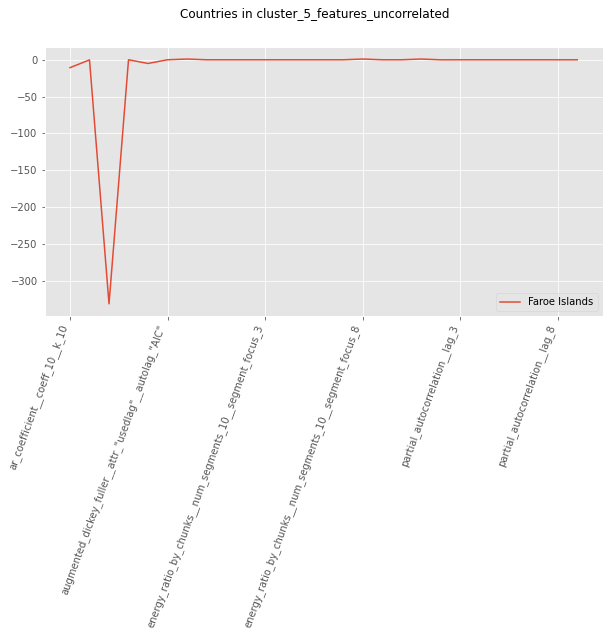

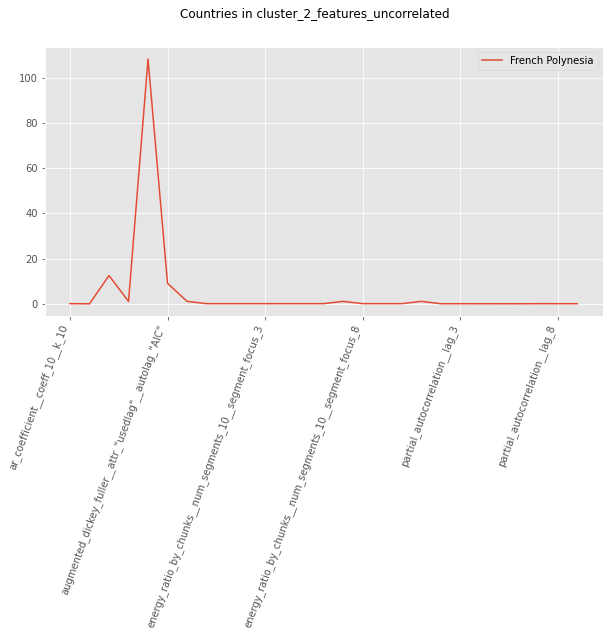

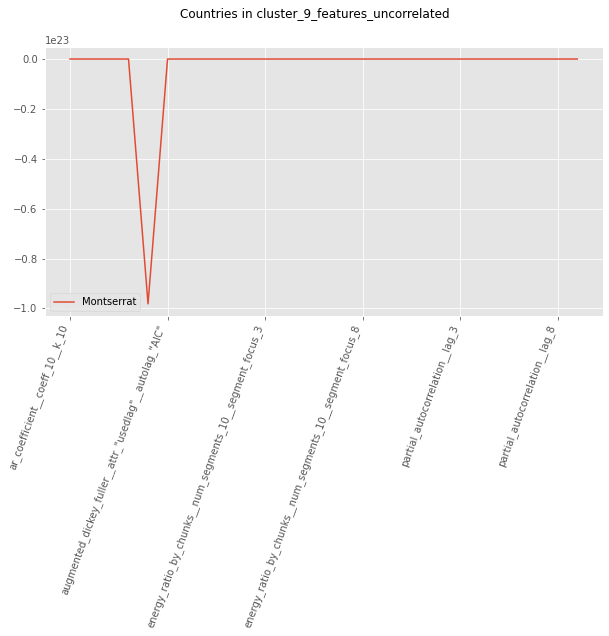

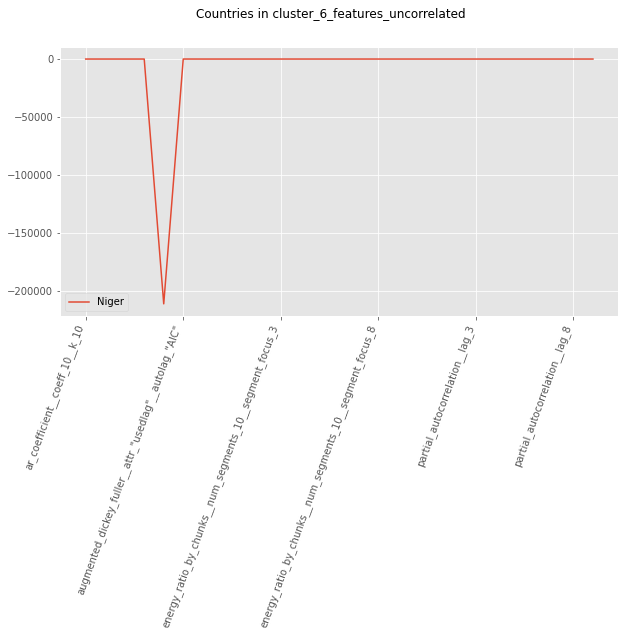

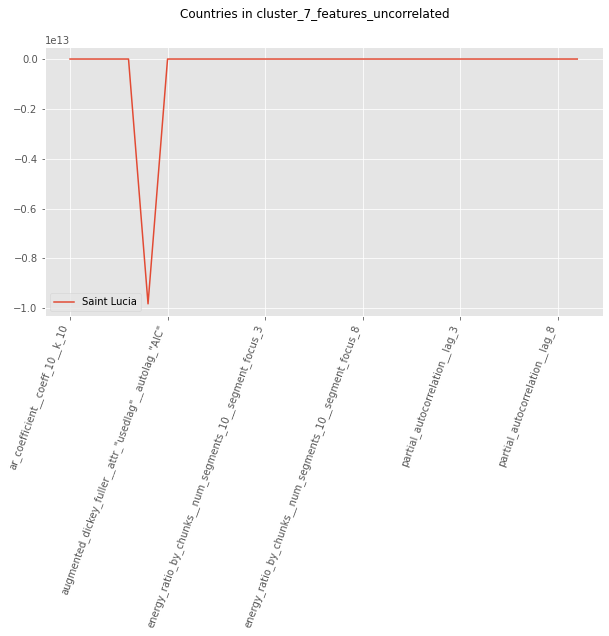

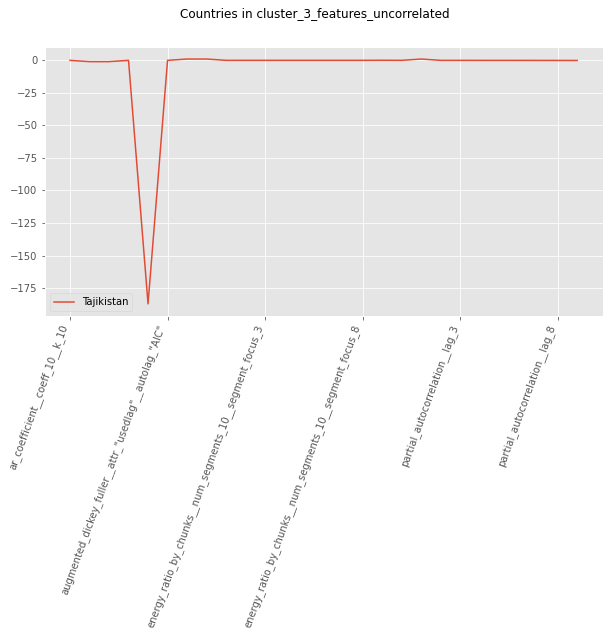

In [46]:
# feats_clf = AgglomerativeClustering(n_clusters=None, distance_threshold = 0).fit(min_feats_yarn.values)
product_name =  'Trial'
plt.figure(figsize = (14,6))
# plot the top five levels of the dendrogram
linkage_matrix = plot_dendrogram(features_uncorrelated.T,f"{product_name}_stats_feats", p=3,color_threshold = 110,truncate_mode='level')
plt.show()

# # extract clusters from dendogram
clusters = fcluster(linkage_matrix, 100, criterion='distance')
# # create a lookup table for series in a given cluster
features_uncorrelated_clusters = features_uncorrelated.reset_index()
features_uncorrelated_clusters["cluster"] = clusters
clusts = np.unique(clusters)
print(f'Unique clusters: {clusts}')
features_uncorrelated_clusters.rename(columns={'id':'country'},inplace=True)
features_uncorrelated_clustered = features_uncorrelated_clusters.set_index("cluster country".split())\
.sort_index()


# cluster analysis
feats_clusters = features_uncorrelated_clusters.cluster.unique()
for c in feats_clusters:
  countries= features_uncorrelated_clustered.loc[c].index.get_level_values(0).unique()
  random.seed(1)
  n_samples = features_uncorrelated_clustered.loc[c].shape[0]
  if n_samples > 10:
    n = random.sample(range(n_samples),10)
  else:
    n = range(n_samples)
  cluster = features_uncorrelated_clustered.loc[c].T
  cluster.iloc[:, n].plot(subplots=True,figsize=(10,5.5),
                          title=f"Countries in cluster_{c}_features_uncorrelated")
  plt.xticks(rotation=70)
  plt.legend(countries)
  plt.savefig(f"{PATH}/images/cluster_{c}_min_feats")
  plt.show()

## K-means clustering

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight

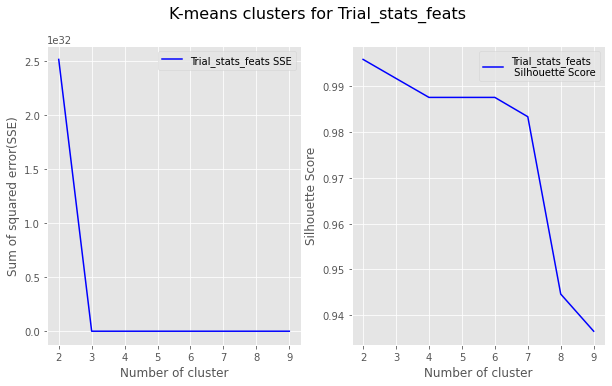

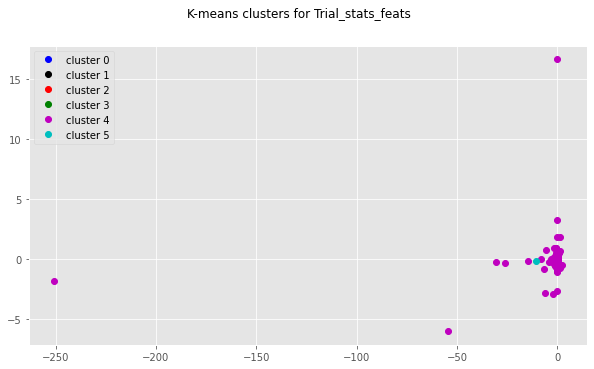

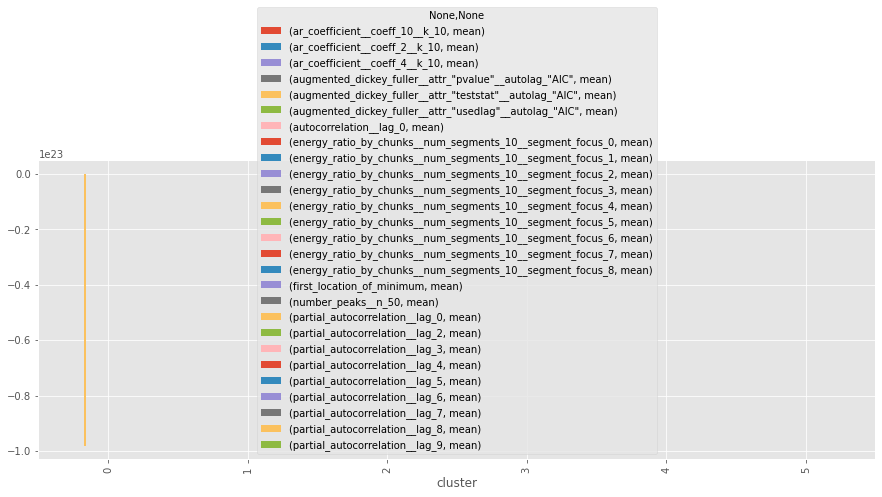

In [49]:
plot_elbow_silhoutte_k_evaluation(f"{product_name}_stats_feats",features_uncorrelated,10)  
clusters_features_uncorrelated = plot_kmeans_clusters(X_scaled_transposed,6,f"{product_name}_stats_feats") #TODO: seperate def get_clusters() \\ plot_kmeans_clusters()

#TODO: function for getting names from cluster
# def get_cluster_elements()
details = [(name,cluster) for name, cluster in zip(features_uncorrelated.index,clusters_features_uncorrelated)]
cluster_df = pd.DataFrame(details,columns=['names','cluster'])
cluster_df['names'].astype('category')
get_names = features_uncorrelated.reset_index().rename(columns={'id':'names'})
get_names.names.astype('category')
country_cluster = pd.merge(get_names,cluster_df,how='inner', on='names')
metrics = ['mean']
groups = country_cluster.groupby(['cluster']).agg(metrics)
ax = groups.plot(figsize=(15,5.5),kind='bar')
fig = ax.get_figure()
fig.savefig(f"{product_name}_min_features_kmeans")
# country_cluster[country_cluster.cluster==1]['names'].unique()

## PCA + k-Means

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


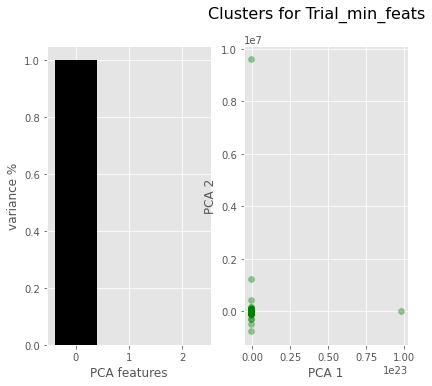

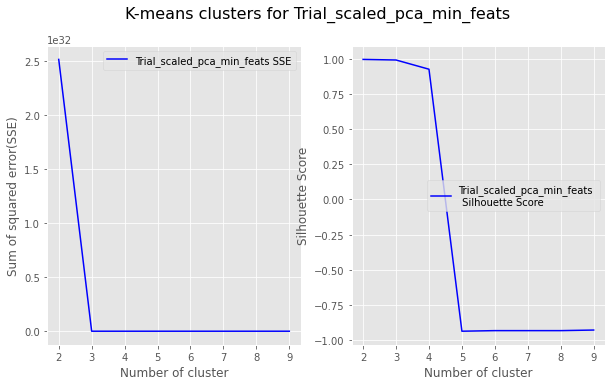

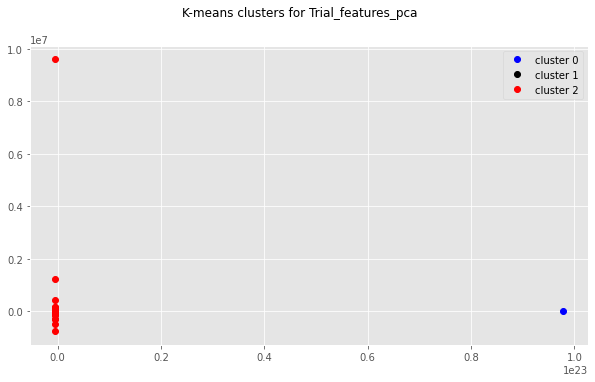

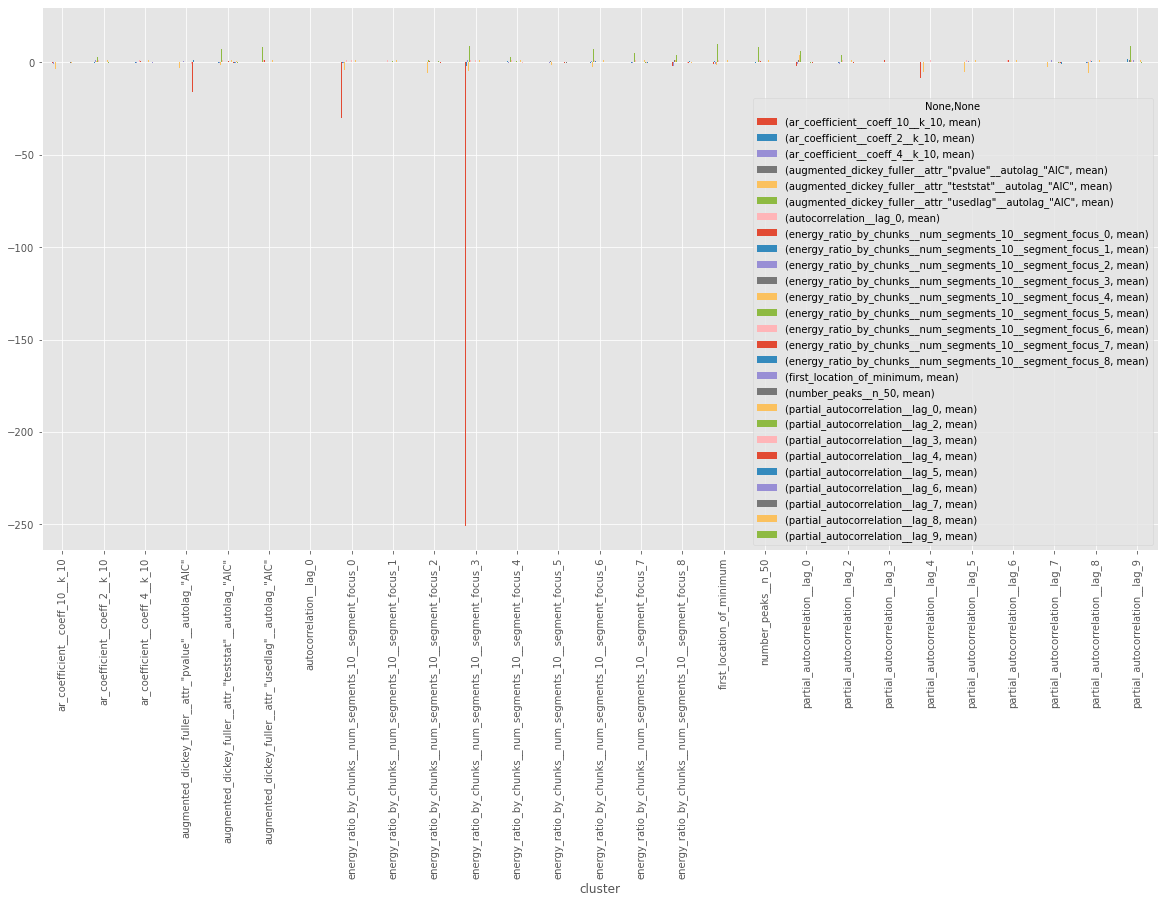

In [50]:
# Standardize the data to have a mean of ~0 and a variance of 1

# TODO: PCA plots and evaluation
# Create a PCA instance: pca
# def calculate_pca():
  # return pca_components_df

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(features_uncorrelated)

# def plot_pca_eveluation():
# Plot the explained variances
features = range(pca.n_components_)

fig = plt.figure(figsize=(10,5.5))
fig.suptitle(f"Clusters for {product_name}_min_feats", fontsize=16)
fig.add_subplot(131)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
fig.add_subplot(132)
plt.scatter(PCA_components[0], PCA_components[1], alpha=.4, color='green')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')


plot_elbow_silhoutte_k_evaluation(f"{product_name}_scaled_pca_min_feats",np.asarray(PCA_components),10)  
clusters_features_uncorrelated = plot_kmeans_clusters(np.asarray(PCA_components),3,f"{product_name}_features_pca")

details = [(name,cluster) for name, cluster in zip(features_uncorrelated.index,features_uncorrelated)]
cluster_df = pd.DataFrame(details,columns=['names','cluster'])
cluster_df['names'].astype('category')
get_names = features_uncorrelated.reset_index().rename(columns={'id':'names'})
get_names.names.astype('category')
country_cluster = pd.merge(get_names,cluster_df,how='inner', on='names')
metrics = ['mean']
groups = country_cluster.groupby(['cluster']).agg(metrics)

ax = groups.plot(figsize=(20,10),kind='bar')
fig = ax.get_figure()
fig.savefig(f"{product_name}_min_features_pca_kmeans.png")

## DBSCAN

### Hyperparameter tuning

  0%|          | 1/245 [00:00<00:28,  8.64it/s]

[dbscan] >Normalize data (unit variance, zero-mean).
[dbscan] Gridsearch on epsilon to determine optimal clusters using silhouette scores.


100%|██████████| 245/245 [00:26<00:00,  9.22it/s]

[clusteval] >Fin.


<Figure size 720x396 with 0 Axes>

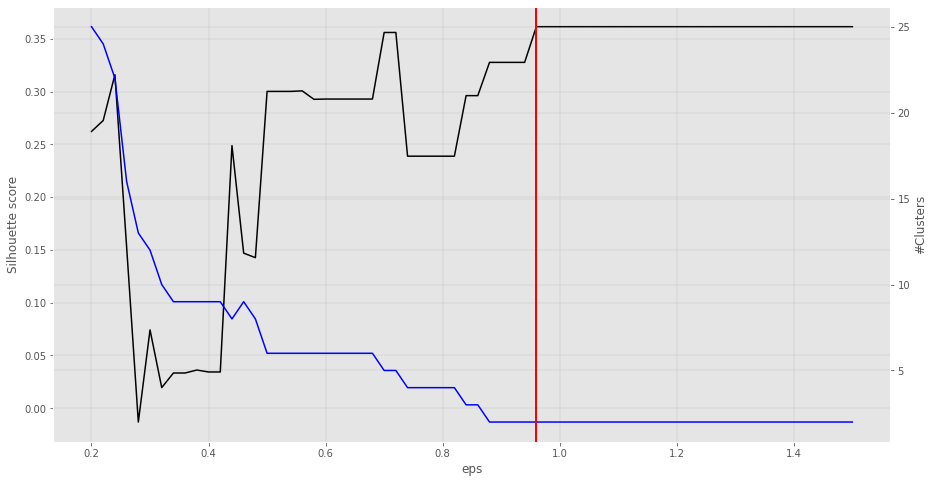

[silhouette] >Estimated number of n_clusters: 1, average silhouette_score=0.590


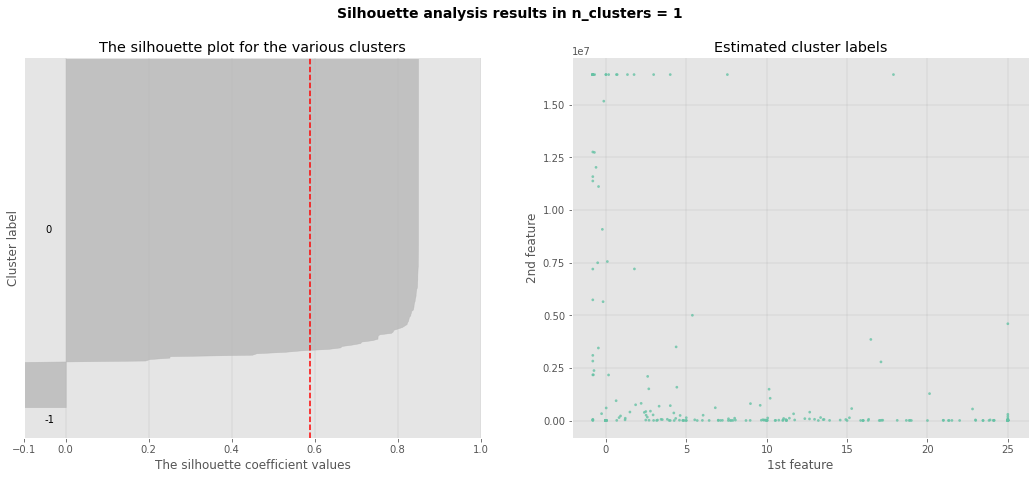

In [ ]:
# https://stackoverflow.com/questions/34611038/grid-search-for-hyperparameter-evaluation-of-clustering-in-scikit-learn
!pip install -q clusteval
# Import library
from clusteval import clusteval
# Set parameters, as an example dbscan
ce = clusteval(method='dbscan')
# Fit to find optimal number of clusters using dbscan
results= ce.fit(X_scaled_transposed)
# Make plot of the cluster evaluation
plt.figure(figsize=(10,5.5))
ce.plot()
# Make scatter plot. Note that the first two coordinates are used for plotting.
ce.scatter(X_scaled_transposed)
# results is a dict with various output statistics. One of them are the labels.
cluster_labels = results['labx']

### DBSCAN clustering

[-1  0  1]
[-1  0  1]


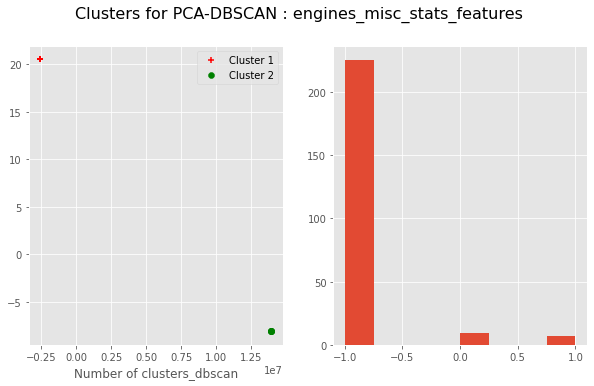

In [ ]:
# https://www.dummies.com/programming/big-data/data-science/how-to-create-an-unsupervised-learning-model-with-dbscan/

dbscan = DBSCAN(eps=0.5, min_samples=5,metric='euclidean')
dbscan_results_yarn = dbscan.fit(X_scaled_transposed)
print(np.unique(dbscan.labels_))

dbscan = DBSCAN(eps=0.5, min_samples=5,metric='euclidean')
dbscan.fit(X_scaled_transposed)
fig = plt.figure(figsize=(10,5.5))
fig.suptitle(f"Clusters for PCA-DBSCAN : {product_name}_stats_features", fontsize=16)
print(np.unique(dbscan.labels_))
fig.add_subplot(121)
# fig.set_title('Clusters')
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X_scaled_transposed)
for i in range(0, pca_2d.shape[0]):
  if dbscan.labels_[i] == 0:
    c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
  elif dbscan.labels_[i] == 1:
    c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
  # elif dbscan.labels_[i] == 2:
  #   c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')
  # elif dbscan.labels_[i] == 3:
  #   c4 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='y',marker='x')
  # elif dbscan.labels_[i] == 4:
  #   c5 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='*')
  # elif dbscan.labels_[i] == 5:
  #   c6 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='x')
  # elif dbscan.labels_[i] == -1:
  #   c7 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='c',marker='+')
plt.xlabel("Number of clusters_dbscan")
plt.legend([c1, c2], ['Cluster 1', 
                                'Cluster 2',
                                'Cluster 3',
                                'Cluster 4',
                                'Cluster 5',
                                'Cluster 6',
                                'Noise'])

# plt.title('DBSCAN finds 2 clusters and noise')
fig.add_subplot(122)
# plt.set_title=("Cluster instances/frequency")
plt.hist(dbscan.labels_,bins=8)
plt.savefig(f"{PATH}/images/{product_name}_feats_pca_dbscan")
plt.show()